<a href="https://colab.research.google.com/github/MhmodElgazaz/Breast-Cancer-Detection/blob/main/BreastCancerDetection_MIAS_no_image_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras import losses
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def show_image(image):
    plt.imshow(image)
    plt.show()

In [ ]:
def create_mias_dataset(file_path: str) -> pd.DataFrame:
    ''' Creates a dataset with the data about the scans '''
    # create a dataset
    mammo = pd.read_table(file_path, delimiter='\s', engine='python')
    # rename the class column to avoid conflicts with the class keyword in python
    mammo.columns = ['refnum', 'bg', 'ab_class', 'severity', 'x', 'y', 'radius']
    # fill null severity with A for NORM class
    # mammo.severity = mammo.severity.fillna('A')
    # drop duplicates
    mammo.drop_duplicates(subset='refnum', keep='first', inplace=True)
    # set refnum as index
    # mammo.set_index(keys='refnum', drop=True, inplace=True)

    return mammo

In [ ]:
mias = create_mias_dataset('/content/drive/MyDrive/Dataset/Info.txt')
mias

,refnum,bg,ab_class,severity,x,y,radius
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,None,NaN,NaN,NaN
3,mdb004,D,NORM,None,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,None,NaN,NaN,NaN
326,mdb319,D,NORM,None,NaN,NaN,NaN
327,mdb320,D,NORM,None,NaN,NaN,NaN
328,mdb321,D,NORM,None,NaN,NaN,NaN


In [ ]:
# drop nan in severity which indicate norm
mias.dropna(subset=['severity'], inplace=True)
mias.reset_index(inplace=True)
mias.drop(['index'],axis=1,inplace=True)
mias

,refnum,bg,ab_class,severity,x,y,radius
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb005,F,CIRC,B,477.0,133.0,30.0
3,mdb010,F,CIRC,B,525.0,425.0,33.0
4,mdb012,F,CIRC,B,471.0,458.0,40.0
...,...,...,...,...,...,...,...
110,mdb274,F,MISC,M,127.0,505.0,123.0
111,mdb290,D,CIRC,B,337.0,353.0,45.0
112,mdb312,F,MISC,B,240.0,263.0,20.0
113,mdb314,F,MISC,B,518.0,191.0,39.0


In [ ]:
# B = 0 index
# M = 1 index
lb = LabelEncoder()
mias['severity'] = lb.fit_transform(mias['severity'])
encoded_labels  = to_categorical(mias['severity'])

In [ ]:
# images path
path= '/content/drive/MyDrive/Dataset/all-mias/'
no_angles = 360

In [ ]:
# def read_images_labels():
#   # define the every images filepaths in to list
#   images = []
#   labels=[]

#   for i in range(len(mias)):

#     image_address= path + mias.refnum[i]+ '.pgm'
#     img = cv2.imread(image_address,1)
#     img = cv2.resize(img, (224,224))   #resize image
#     rows, cols,color = img.shape

#     for angle in range(0,no_angles,8):

#       M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
#       img_rotated = cv2.warpAffine(img, M, (cols, rows))

#       images.append(img_rotated)
#       labels.append(encoded_labels[i])

#   return images, labels

In [ ]:
def read_images_labels():
    # define the every images filepaths in to list
    images = []
    labels = []

    for i in range(len(mias)):
        image_address = path + mias.refnum[i] + '.pgm'
        img = cv2.imread(image_address, 1)
        img = cv2.resize(img, (224, 224))  # resize image
        images.append(img)
        labels.append(encoded_labels[i])

    return images, labels

In [ ]:
X, Y = read_images_labels()

In [ ]:
X = np.asarray(X)
X.shape

(115, 224, 224, 3)

In [ ]:
Y = np.array(Y)
Y.shape

(115, 2)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=2021,shuffle=True)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
       return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
from tensorflow.keras.regularizers import l2
base_model = DenseNet121(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_regularizer=l2(0.01), kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 batch_normalization (Batch  (None, 50176)             200704    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              40

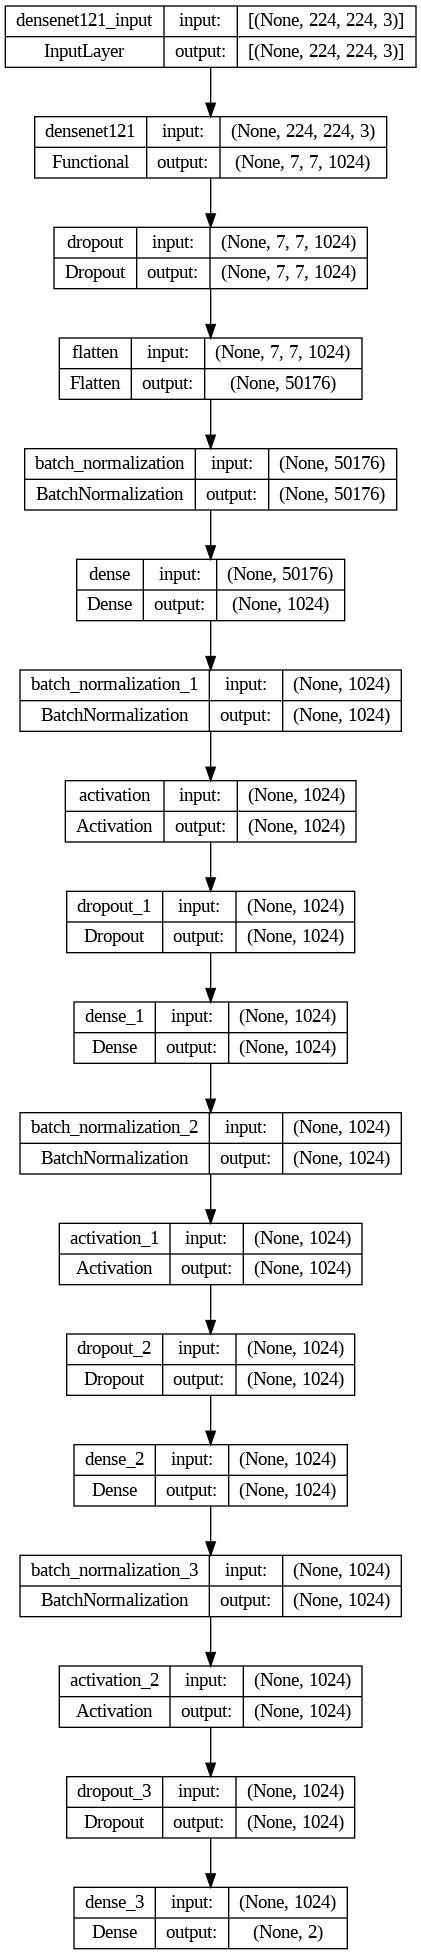

In [ ]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image

plot_model(model, to_file='model_architecture.png' ,show_shapes=True, show_layer_names=True)
Image(filename='model_architecture.png')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=12,restore_best_weights=True, verbose=1)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    x_train, y_train, validation_split=0.15,
    shuffle=True, epochs=150, batch_size=128,
    callbacks=[es],
    class_weight={0: 1, 1: 1.5}  # Adjust class weights as needed
)

Epoch 1/150
1/1 [==============================] - 13s 13s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.8329 - val_accuracy: 0.6000
Epoch 2/150
1/1 [==============================] - 0s 386ms/step - loss: 1.9885 - accuracy: 0.6463 - val_loss: 2.8173 - val_accuracy: 0.4000
Epoch 3/150
1/1 [==============================] - 0s 340ms/step - loss: 0.5842 - accuracy: 0.8537 - val_loss: 4.1288 - val_accuracy: 0.4000
Epoch 4/150
1/1 [==============================] - 0s 342ms/step - loss: 0.2660 - accuracy: 0.9878 - val_loss: 3.6562 - val_accuracy: 0.4667
Epoch 5/150
1/1 [==============================] - 0s 339ms/step - loss: 0.1304 - accuracy: 0.9878 - val_loss: 3.5888 - val_accuracy: 0.5333
Epoch 6/150
1/1 [==============================] - 0s 319ms/step - loss: 0.0977 - accuracy: 1.0000 - val_loss: 4.1728 - val_accuracy: 0.5333
Epoch 7/150
1/1 [==============================] - 0s 343ms/step - loss: 0.1039 - accuracy: 1.0000 - val_loss: 5.0301 - val_accuracy: 0.5333
Epoch 8/150
1/

In [ ]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

1/1 [==============================] - 0s 106ms/step - loss: 0.5688 - accuracy: 0.6667
Test_loss_value = 0.5688151717185974
test_accuracy = 0.6666666865348816


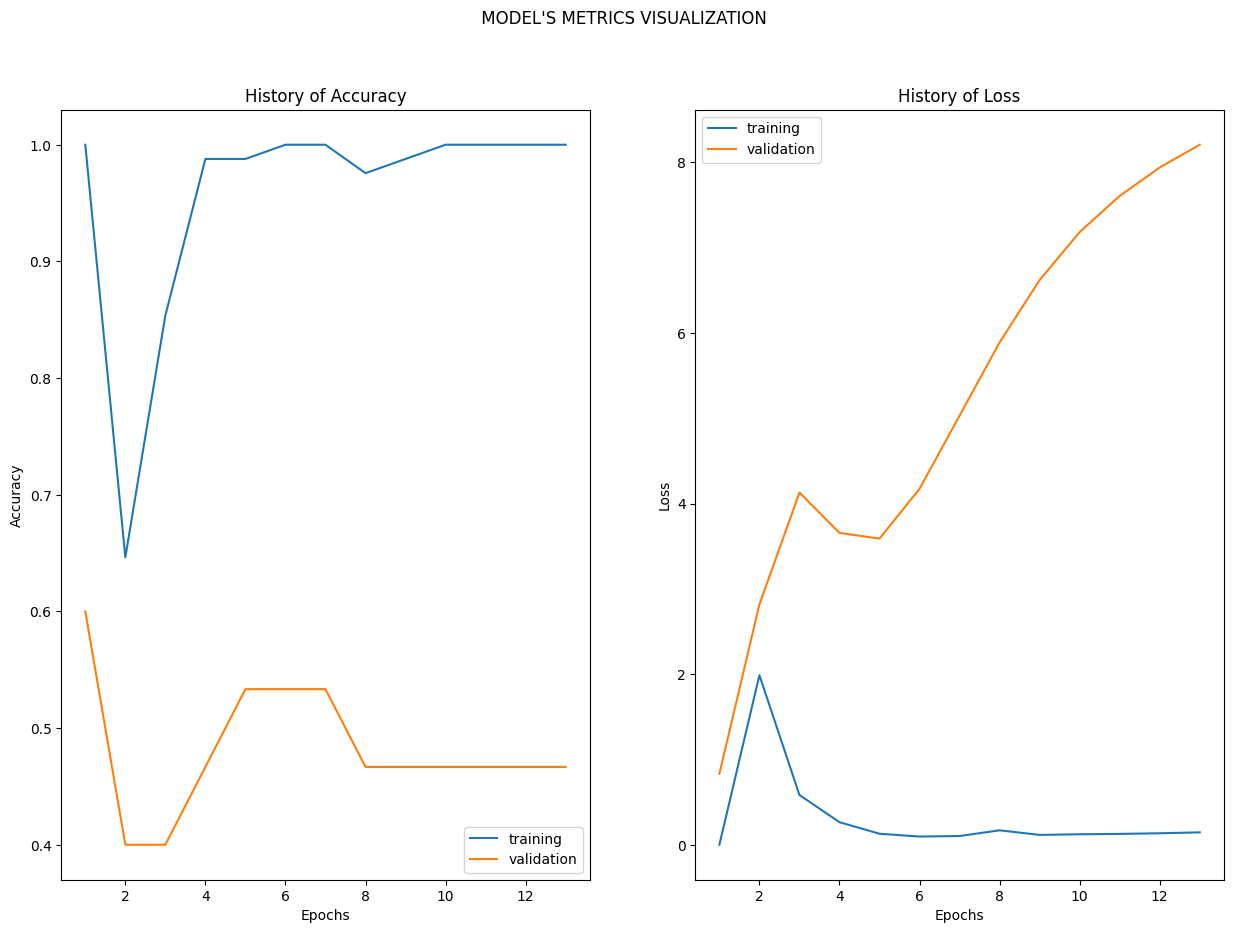

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [ ]:
predictions = model.predict(x_test)
y_pred = [np.argmax(w) for w in predictions]

1/1 [==============================] - 2s 2s/step


In [ ]:
y_test = [np.argmax(w) for w in y_test]

<Axes: title={'center': 'the confusion matrix of the model in the train'}>

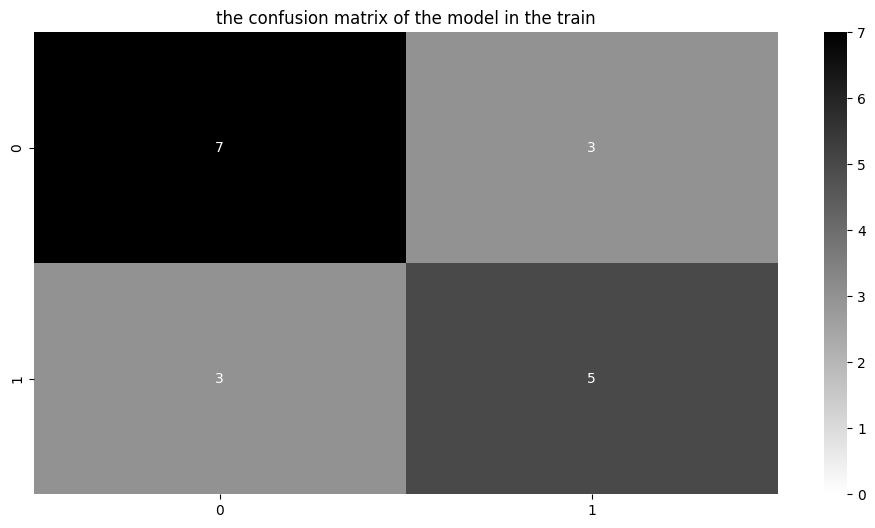

In [ ]:
cm1 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
plt.title('the confusion matrix of the model in the train')
sns.heatmap(cm1, annot = True, fmt = 'g' ,vmin = 0, cmap = 'binary')

In [ ]:
label_mapping = {
    1: 'M',
    0: 'B'
}

classification_report_model = classification_report(y_test, y_pred, target_names=label_mapping.values())
print(classification_report_model)

              precision    recall  f1-score   support

           M       0.70      0.70      0.70        10
           B       0.62      0.62      0.62         8

    accuracy                           0.67        18
   macro avg       0.66      0.66      0.66        18
weighted avg       0.67      0.67      0.67        18



In [ ]:
tf.saved_model.save(model,'model')
model.save('Final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
trained_model = tf.keras.models.load_model('Final_model.h5')

from PIL import Image, ImageOps
import numpy as np

def preprocess_image(image_input):
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
    image = Image.open(image_input).convert('RGB')
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.LANCZOS)
    image_array = np.asarray(image)
    data[0] = image_array
    return data

def make_prediction(model, image_data):
    prediction = model.predict(image_data)
    class1 = prediction[0, 0]
    class2 = prediction[0, 1]
    return class1, class2

def show_image_from_path(image_path):
    # Read the image using cv2.imread
    img = cv2.imread(image_path, 1)
    img = cv2.resize(img, (224,224))
    # Display the image using plt.imshow
    plt.imshow(img)
    plt.show()




1/1 [==============================] - 4s 4s/step
Prediction for /content/drive/MyDrive/Test/0/1025_1803952236.png:
Benign Tumor


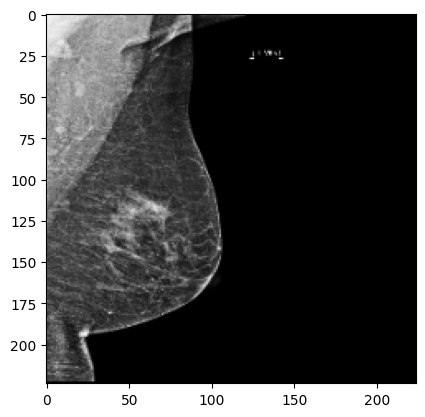

1/1 [==============================] - 0s 33ms/step
Prediction for /content/drive/MyDrive/Test/0/10006_1459541791.png:
Benign Tumor


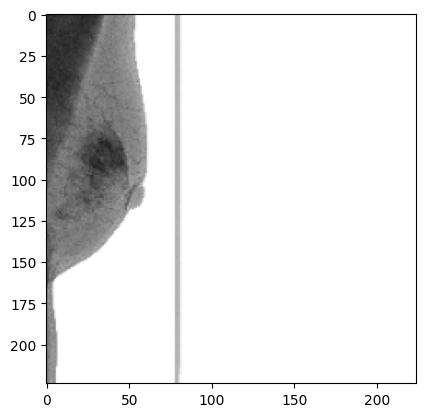

1/1 [==============================] - 0s 30ms/step
Prediction for /content/drive/MyDrive/Test/0/10011_220375232.png:
Benign Tumor


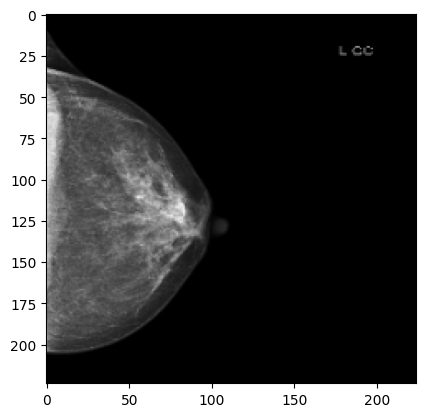

1/1 [==============================] - 0s 36ms/step
Prediction for /content/drive/MyDrive/Test/0/10025_1365269360.png:
Benign Tumor


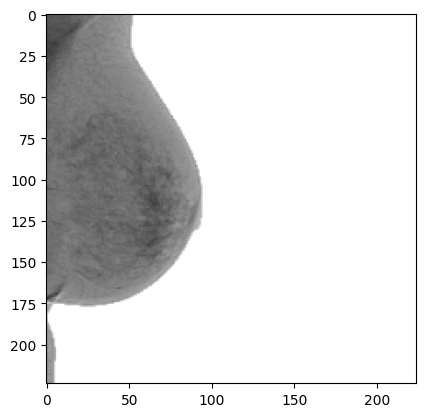

1/1 [==============================] - 0s 30ms/step
Prediction for /content/drive/MyDrive/Test/0/10049_906829939.png:
Benign Tumor


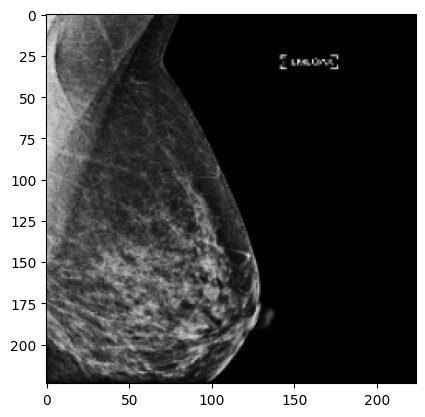

1/1 [==============================] - 0s 32ms/step
Prediction for /content/drive/MyDrive/Test/0/10038_850559196.png:
Benign Tumor


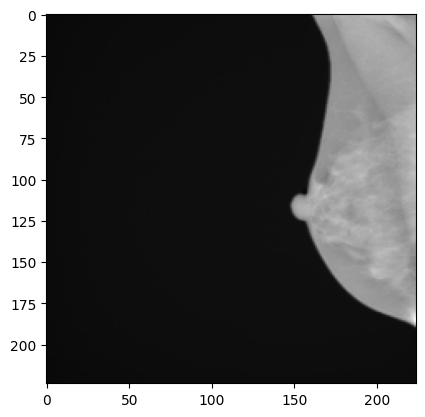

In [ ]:
import os

# Assuming you have a folder containing multiple images for prediction
folder_path = '/content/drive/MyDrive/Test/0/'
image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.png')]

for image_path in image_paths:
    # Preprocess the image
    preprocessed_data = preprocess_image(image_path)

    # Make prediction
    class1_prob, class2_prob = make_prediction(trained_model, preprocessed_data)

    # Display the prediction result
    print(f"Prediction for {image_path}:")
    if class1_prob > class2_prob:
        print("Benign Tumor")
    elif class2_prob > class1_prob:
        print("Malignant Tumor")
    else:
        print("We encountered an ERROR. This should be temporary. Please try again with a better quality image. Cheers!")

    show_image_from_path(image_path)

1/1 [==============================] - 0s 31ms/step
Prediction for /content/drive/MyDrive/Test/1/10130_1360338805.png:
Benign Tumor Probability: 0.8180
Malignant Tumor Probability: 0.1820
Predicted Class: Benign Tumor


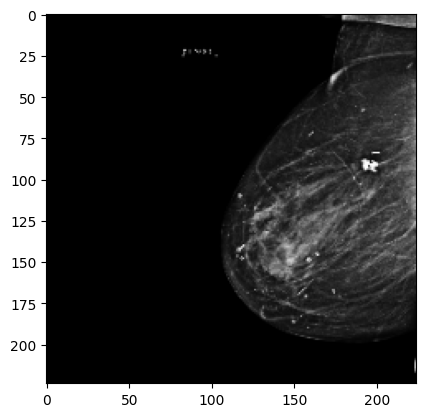

1/1 [==============================] - 0s 32ms/step
Prediction for /content/drive/MyDrive/Test/1/10226_461614796.png:
Benign Tumor Probability: 0.7643
Malignant Tumor Probability: 0.2357
Predicted Class: Benign Tumor


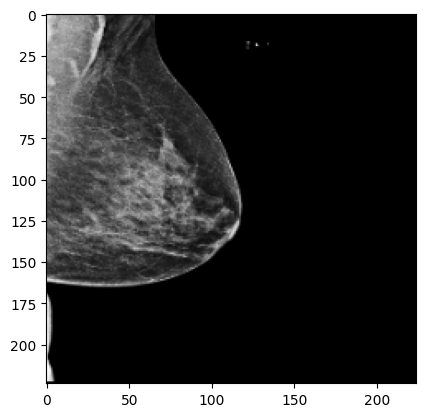

1/1 [==============================] - 0s 29ms/step
Prediction for /content/drive/MyDrive/Test/1/10130_1672636630.png:
Benign Tumor Probability: 0.8482
Malignant Tumor Probability: 0.1518
Predicted Class: Benign Tumor


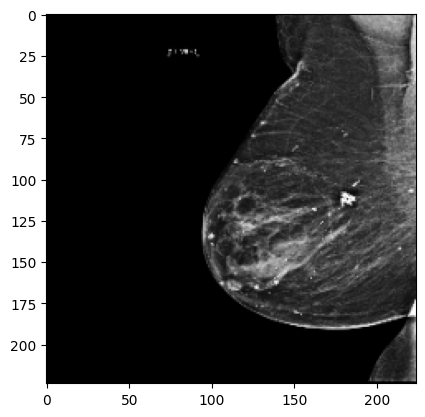

1/1 [==============================] - 0s 31ms/step
Prediction for /content/drive/MyDrive/Test/1/11094_1417771843.png:
Benign Tumor Probability: 0.8412
Malignant Tumor Probability: 0.1588
Predicted Class: Benign Tumor


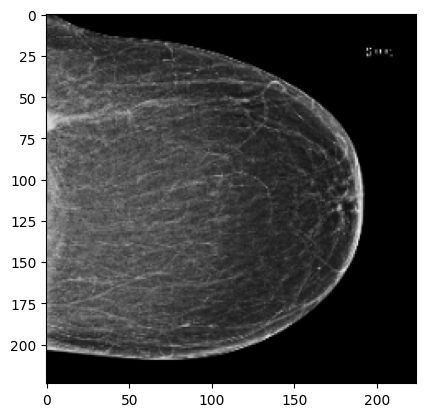

1/1 [==============================] - 0s 30ms/step
Prediction for /content/drive/MyDrive/Test/1/11249_1820235658.png:
Benign Tumor Probability: 0.8493
Malignant Tumor Probability: 0.1507
Predicted Class: Benign Tumor


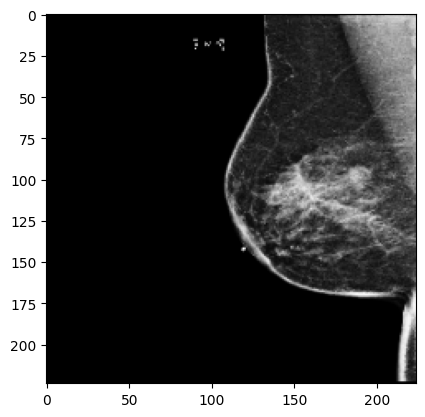

1/1 [==============================] - 0s 32ms/step
Prediction for /content/drive/MyDrive/Test/1/1025_1803952236.png:
Benign Tumor Probability: 0.6975
Malignant Tumor Probability: 0.3025
Predicted Class: Benign Tumor


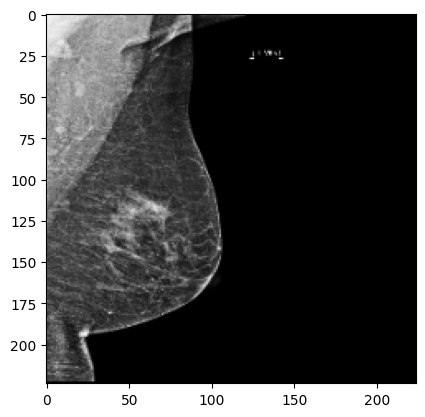

1/1 [==============================] - 0s 49ms/step
Prediction for /content/drive/MyDrive/Test/1/10432_458553546.png:
Benign Tumor Probability: 0.8110
Malignant Tumor Probability: 0.1890
Predicted Class: Benign Tumor


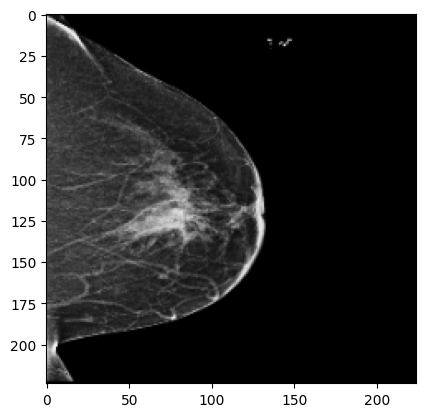

In [ ]:
import os

# Assuming you have a folder containing multiple images for prediction
folder_path = '/content/drive/MyDrive/Test/1/'
image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.png')]

for image_path in image_paths:
    # Preprocess the image
    preprocessed_data = preprocess_image(image_path)

    # Make prediction
    class1_prob, class2_prob = make_prediction(trained_model, preprocessed_data)

    # Display the prediction result
    print(f"Prediction for {image_path}:")
    print(f"Benign Tumor Probability: {class1_prob:.4f}")
    print(f"Malignant Tumor Probability: {class2_prob:.4f}")

    if class1_prob > class2_prob:
        print("Predicted Class: Benign Tumor")
    elif class2_prob > class1_prob:
        print("Predicted Class: Malignant Tumor")
    else:
        print("We encountered an ERROR. This should be temporary. Please try again with a better quality image. Cheers!")

    show_image_from_path(image_path)
